# RESULTS

1. /data/lucayu/lss-cfar/dataset/cx_corridor_2024-08-27/test/cx_corridor_2024-08-27_21-06-22.pickle
2. /data/lucayu/lss-cfar/dataset/lucacx_corridor_2024-08-27/test/lucacx_corridor_2024-08-27_21-40-13.pickle

In [19]:
import pickle
import os
import torch
from loguru import logger
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage import label, find_objects
from model import LSSLModel

# Load model function
def load_model(checkpoint_path):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = LSSLModel(
        num_layers=2,
        d=256,
        order=256,
        dt_min=1e-3,
        dt_max=8e-5,
        channels=1,
        dropout=0.1
    ).to(device)

    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    return model, device

# Load calibration spectrum
def load_calibration_spectrum(calibration_path):
    calibration_files = os.listdir(calibration_path)
    calibration_spectrum = torch.zeros(87, 128)
    for calibration_file in calibration_files:
        with open(os.path.join(calibration_path, calibration_file), 'rb') as f:
            calibration_data = pickle.load(f)
        calibration_data = calibration_data['spectrum']
        calibration_data = torch.tensor(calibration_data, dtype=torch.float32).flip(0)
        calibration_data = calibration_data[:, 14:]
        calibration_spectrum += torch.tensor(calibration_data, dtype=torch.float32)
    calibration_spectrum /= len(calibration_files)
    return calibration_spectrum

# Load data function
def load_data(data_path):
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    spectrum = torch.tensor(data['spectrum'], dtype=torch.float32)[:, 14:]
    pointcloud = torch.tensor(data['pointcloud'], dtype=torch.float32)[:, 14:]
    return spectrum, pointcloud

# Process data function
def process_data(spectrum, pointcloud, calibration_spectrum=None):
    if calibration_spectrum is not None:
        spectrum = spectrum - calibration_spectrum
        pointcloud = torch.where(pointcloud == 1, torch.tensor(0), pointcloud)
        pointcloud = torch.where(pointcloud == 2, torch.tensor(1), pointcloud)

    spectrum = spectrum.flatten()
    pointcloud = pointcloud.flatten()
    return spectrum, pointcloud

# Predict pointcloud function
def predict_pointcloud(model, spectrum, device):
    with torch.no_grad():
        spectrum_input = spectrum.unsqueeze(0).to(device)
        pointcloud_pred = model(spectrum_input)
    return pointcloud_pred

# Find the largest closure bbox
def find_largest_closure_bbox(matrix, h_expand=8):
    labeled_array, num_features = label(matrix)
    bounding_boxes = find_objects(labeled_array)
    
    if not bounding_boxes:
        return []
    
    max_bbox = max(bounding_boxes, key=lambda bbox: (bbox[0].stop - bbox[0].start) * (bbox[1].stop - bbox[1].start))
    
    r1, c1, r2, c2 = max_bbox[0].start, max_bbox[1].start, max_bbox[0].stop, max_bbox[1].stop
    return [slice(r1, r2), slice(c1, c2)]

# Visualization function with beautified axes and proper spectrum saving
# Visualization function with points differentiation and legend
def visualize_sample(spectrum_np, pointcloud_pred_np, pointcloud_gt_np, bboxes, save_base_path):
    # Threshold and binarize the predicted mask
    pointcloud_pred_np = np.where(pointcloud_pred_np > pointcloud_pred_np.max() * 0.8, 1, 0)

    # Define axis limits and labels
    x_ticks = np.linspace(0, 128-1, 6)  # 6 evenly spaced ticks between 0 and 128
    x_labels = np.linspace(0.6, 6, 6)  # Convert to meters (0.6m - 6m)

    y_ticks = np.linspace(0, 87-1, 6)  # 6 evenly spaced ticks between 0 and 87
    y_labels = np.linspace(43.5, -43.5, 6)  # Convert to degrees (43.5° to -43.5°)

    # Plot figure 3: Ground Truth Pointcloud with two bounding boxes
    fig_gt, ax_gt = plt.subplots(figsize=(7, 7), facecolor='none')
    ax_gt.imshow(pointcloud_gt_np, cmap='gray', aspect='equal')  # 'aspect' set to 'equal' for square pixels
    ax_gt.set_xticks(x_ticks)
    ax_gt.set_xticklabels([f'{x:.1f}' for x in x_labels], fontsize=24)
    ax_gt.set_yticks(y_ticks)
    ax_gt.set_yticklabels([f'{y:.1f}' for y in y_labels], fontsize=24)
    ax_gt.set_xlabel('Range / m', fontsize=32)
    ax_gt.set_ylabel('Azimuth / deg', fontsize=32)

    # Draw the two largest bounding boxes
    colors = ['red', 'green']
    for i, bbox in enumerate(bboxes):
        r1, r2 = bbox[0].start, bbox[0].stop
        c1, c2 = bbox[1].start, bbox[1].stop
        rect = patches.Rectangle((c1, r1), c2 - c1, r2 - r1, linewidth=2, edgecolor=colors[i % 2], facecolor='none', label=f"BBox {i+1}")
        ax_gt.add_patch(rect)

    # Get the coordinates of the points from the predicted mask
    predicted_points = np.argwhere(pointcloud_pred_np == 1)

    # Define function to check if a point is inside a bbox
    def is_point_in_bbox(point, bbox):
        r1, r2 = bbox[0].start, bbox[0].stop
        c1, c2 = bbox[1].start, bbox[1].stop
        return r1 <= point[0] <= r2 and c1 <= point[1] <= c2

    # Plot points: blue if inside any bbox, red if outside all bboxes
    inside_points = []
    outside_points = []
    for point in predicted_points:
        inside_any_bbox = any(is_point_in_bbox(point, bbox) for bbox in bboxes)
        if inside_any_bbox:
            inside_points.append(point)
        else:
            outside_points.append(point)

    # Plot inside (blue) and outside (red) points
    inside_points = np.array(inside_points)
    outside_points = np.array(outside_points)
    
    if len(inside_points) > 0:
        ax_gt.plot(inside_points[:, 1], inside_points[:, 0], 'bo', markersize=5, label='Inside BBox')
    if len(outside_points) > 0:
        ax_gt.plot(outside_points[:, 1], outside_points[:, 0], 'ro', markersize=5, label='Outside BBox')

    # Add legend
    ax_gt.legend(fontsize=16, loc='upper left')

    fig_gt.tight_layout()
    fig_gt.savefig(f"{save_base_path}_ground_truth_with_points.pdf", format='pdf', bbox_inches='tight')
    plt.close(fig_gt)


def main(data_path, calibration_path, checkpoint_path):
    # Load the model and device
    model, device = load_model(checkpoint_path)

    # Load calibration spectrum
    calibration_spectrum = load_calibration_spectrum(calibration_path)

    # Load data (spectrum and pointcloud)
    spectrum, pointcloud = load_data(data_path)

    # Process data
    spectrum, pointcloud = process_data(spectrum, pointcloud, calibration_spectrum)

    # Predict the pointcloud
    pointcloud_pred = predict_pointcloud(model, spectrum, device)
    
    pointcloud_pred_np = pointcloud_pred.squeeze().detach().cpu().view(87, 128).numpy()
    pointcloud_gt_np = pointcloud.view(87, 128).numpy()
    spectrum_np = spectrum.view(87, 128).numpy()

    # Find the largest closure bounding box
    bboxes = [find_largest_closure_bbox(pointcloud_gt_np)]

    # Visualize and save the sample
    save_base_path = 'figures/sample1'
    visualize_sample(spectrum_np, pointcloud_pred_np, pointcloud_gt_np, bboxes, save_base_path)

if __name__ == '__main__':
    data_path = '/data/lucayu/lss-cfar/dataset/cx_corridor_2024-08-27/test/cx_corridor_2024-08-27_21-06-22.pickle'
    calibration_path = '/data/lucayu/lss-cfar/raw_dataset/cx_env_corridor_2024-08-27'
    checkpoint_path = '/home/lucayu/lss-cfar/checkpoints/20240903-175512_model_layers_2_hidden_256_order_256_dtmin_0.001_dtmax_8e-05_channels_1_dropout_0.0_lr_0.01_batch_4_steps_10000_optimizer_AdamW_decay_0.1_step_300_gamma_0.5_losstype_bce/20240903-175512_model_layers_2_hidden_256_order_256_dtmin_0.001_dtmax_8e-05_channels_1_dropout_0.0_lr_0.01_batch_4_steps_10000_optimizer_AdamW_decay_0.1_step_300_gamma_0.5_losstype_bce.pt'
    
    main(data_path, calibration_path, checkpoint_path)


/tmp/ipykernel_3285801/4055867960.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
/tmp/ipykernel_3285801/4055867960.p

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import label, find_objects

# Function to find two largest closure bounding boxes
def find_two_largest_closure_bboxes(matrix):
    labeled_array, num_features = label(matrix)
    bounding_boxes = find_objects(labeled_array)
    # bounding_boxes are sorted by size in descending order.
    bounding_boxes = sorted(bounding_boxes, key=lambda bbox: (bbox[0].stop - bbox[0].start) * (bbox[1].stop - bbox[1].start), reverse=True)

    expanded_bboxes = []
    for bbox in bounding_boxes[:2]:
        r1, c1 = bbox[0].start, bbox[1].start
        r2, c2 = bbox[0].stop, bbox[1].stop
        expanded_bboxes.append((slice(r1, r2), slice(c1, c2)))

    return expanded_bboxes

# Visualization function with points differentiation and legend
def visualize_sample(spectrum_np, pointcloud_pred_np, pointcloud_gt_np, bboxes, save_base_path):
    # Threshold and binarize the predicted mask
    pointcloud_pred_np = np.where(pointcloud_pred_np > pointcloud_pred_np.max() * 0.8, 1, 0)

    # Define axis limits and labels
    x_ticks = np.linspace(0, 128-1, 6)  # 6 evenly spaced ticks between 0 and 128
    x_labels = np.linspace(0.6, 6, 6)  # Convert to meters (0.6m - 6m)

    y_ticks = np.linspace(0, 87-1, 6)  # 6 evenly spaced ticks between 0 and 87
    y_labels = np.linspace(43.5, -43.5, 6)  # Convert to degrees (43.5° to -43.5°)

    # Plot figure 1: Spectrum
    fig_spectrum, ax_spectrum = plt.subplots(figsize=(7, 7), facecolor='none')
    ax_spectrum.imshow(spectrum_np, cmap='viridis', aspect='equal')  # Spectrum plot
    ax_spectrum.set_xticks(x_ticks)
    ax_spectrum.set_xticklabels([f'{x:.1f}' for x in x_labels], fontsize=24)
    ax_spectrum.set_yticks(y_ticks)
    ax_spectrum.set_yticklabels([f'{y:.1f}' for y in y_labels], fontsize=24)
    ax_spectrum.set_xlabel('Range / m', fontsize=32)
    ax_spectrum.set_ylabel('Azimuth / deg', fontsize=32)
    fig_spectrum.tight_layout()
    fig_spectrum.savefig(f"{save_base_path}_spectrum.pdf", format='pdf', bbox_inches='tight')
    plt.close(fig_spectrum)

    # Plot figure 2: Predicted Pointcloud Mask
    fig_predicted, ax_predicted = plt.subplots(figsize=(7, 7), facecolor='none')
    ax_predicted.imshow(pointcloud_pred_np, cmap='gray', aspect='equal')  # 'aspect' set to 'equal' for square pixels
    ax_predicted.set_xticks(x_ticks)
    ax_predicted.set_xticklabels([f'{x:.1f}' for x in x_labels], fontsize=24)
    ax_predicted.set_yticks(y_ticks)
    ax_predicted.set_yticklabels([f'{y:.1f}' for y in y_labels], fontsize=24)
    ax_predicted.set_xlabel('Range / m', fontsize=32)
    ax_predicted.set_ylabel('Azimuth / deg', fontsize=32)
    fig_predicted.tight_layout()
    fig_predicted.savefig(f"{save_base_path}_predicted_mask.pdf", format='pdf', bbox_inches='tight')
    plt.close(fig_predicted)

    # Plot figure 3: Ground Truth Pointcloud with two bounding boxes
    fig_gt, ax_gt = plt.subplots(figsize=(7, 7), facecolor='none')
    ax_gt.imshow(pointcloud_gt_np, cmap='gray', aspect='equal')  # 'aspect' set to 'equal' for square pixels
    ax_gt.set_xticks(x_ticks)
    ax_gt.set_xticklabels([f'{x:.1f}' for x in x_labels], fontsize=24)
    ax_gt.set_yticks(y_ticks)
    ax_gt.set_yticklabels([f'{y:.1f}' for y in y_labels], fontsize=24)
    ax_gt.set_xlabel('Range / m', fontsize=32)
    ax_gt.set_ylabel('Azimuth / deg', fontsize=32)

    # Draw the two largest bounding boxes
    colors = ['red', 'green']
    for i, bbox in enumerate(bboxes):
        r1, r2 = bbox[0].start, bbox[0].stop
        c1, c2 = bbox[1].start, bbox[1].stop
        rect = patches.Rectangle((c1, r1), c2 - c1, r2 - r1, linewidth=2, edgecolor=colors[i % 2], facecolor='none', label=f"BBox {i+1}")
        ax_gt.add_patch(rect)

    # Get the coordinates of the points from the predicted mask
    predicted_points = np.argwhere(pointcloud_pred_np == 1)

    # Define function to check if a point is inside a bbox
    def is_point_in_bbox(point, bbox):
        r1, r2 = bbox[0].start, bbox[0].stop
        c1, c2 = bbox[1].start, bbox[1].stop
        return r1 <= point[0] <= r2 and c1 <= point[1] <= c2

    # Plot points: blue if inside any bbox, red if outside all bboxes
    inside_points = []
    outside_points = []
    for point in predicted_points:
        inside_any_bbox = any(is_point_in_bbox(point, bbox) for bbox in bboxes)
        if inside_any_bbox:
            inside_points.append(point)
        else:
            outside_points.append(point)

    # Plot inside (blue) and outside (red) points
    inside_points = np.array(inside_points)
    outside_points = np.array(outside_points)
    
    if len(inside_points) > 0:
        ax_gt.plot(inside_points[:, 1], inside_points[:, 0], 'bo', markersize=5, label='Inside BBox')
    if len(outside_points) > 0:
        ax_gt.plot(outside_points[:, 1], outside_points[:, 0], 'ro', markersize=5, label='Outside BBox')

    # Add legend
    ax_gt.legend(fontsize=16, loc='upper left')

    fig_gt.tight_layout()
    fig_gt.savefig(f"{save_base_path}_ground_truth_with_points.pdf", format='pdf', bbox_inches='tight')
    plt.close(fig_gt)

# Main function with updated bbox function
def main(data_path, calibration_path, checkpoint_path):
    # Load the model and device
    model, device = load_model(checkpoint_path)

    # Load calibration spectrum
    calibration_spectrum = load_calibration_spectrum(calibration_path)

    # Load data (spectrum and pointcloud)
    spectrum, pointcloud = load_data(data_path)

    # Process data
    spectrum, pointcloud = process_data(spectrum, pointcloud, calibration_spectrum)

    # Predict the pointcloud
    pointcloud_pred = predict_pointcloud(model, spectrum, device)
    
    pointcloud_pred_np = pointcloud_pred.squeeze().detach().cpu().view(87, 128).numpy()
    pointcloud_gt_np = pointcloud.view(87, 128).numpy()
    spectrum_np = spectrum.view(87, 128).numpy()

    # Find the two largest closure bounding boxes
    bboxes = find_two_largest_closure_bboxes(pointcloud_gt_np)

    # Visualize and save the sample
    save_base_path = 'figures/sample2'
    visualize_sample(spectrum_np, pointcloud_pred_np, pointcloud_gt_np, bboxes, save_base_path)

if __name__ == '__main__':
    data_path = '/data/lucayu/lss-cfar/dataset/lucacx_corridor_2024-08-27/test/lucacx_corridor_2024-08-27_21-40-03.pickle'
    calibration_path = '/data/lucayu/lss-cfar/raw_dataset/lucacx_env_corridor_2024-08-27'
    checkpoint_path = '/home/lucayu/lss-cfar/checkpoints/20240903-175512_model_layers_2_hidden_256_order_256_dtmin_0.001_dtmax_8e-05_channels_1_dropout_0.0_lr_0.01_batch_4_steps_10000_optimizer_AdamW_decay_0.1_step_300_gamma_0.5_losstype_bce/20240903-175512_model_layers_2_hidden_256_order_256_dtmin_0.001_dtmax_8e-05_channels_1_dropout_0.0_lr_0.01_batch_4_steps_10000_optimizer_AdamW_decay_0.1_step_300_gamma_0.5_losstype_bce.pt'
    
    main(data_path, calibration_path, checkpoint_path)


/tmp/ipykernel_3285801/4055867960.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
/tmp/ipykernel_3285801/4055867960.p

# ROC (NOT REPUBLIC OF CHINA OR TAIWAN🇹🇼)

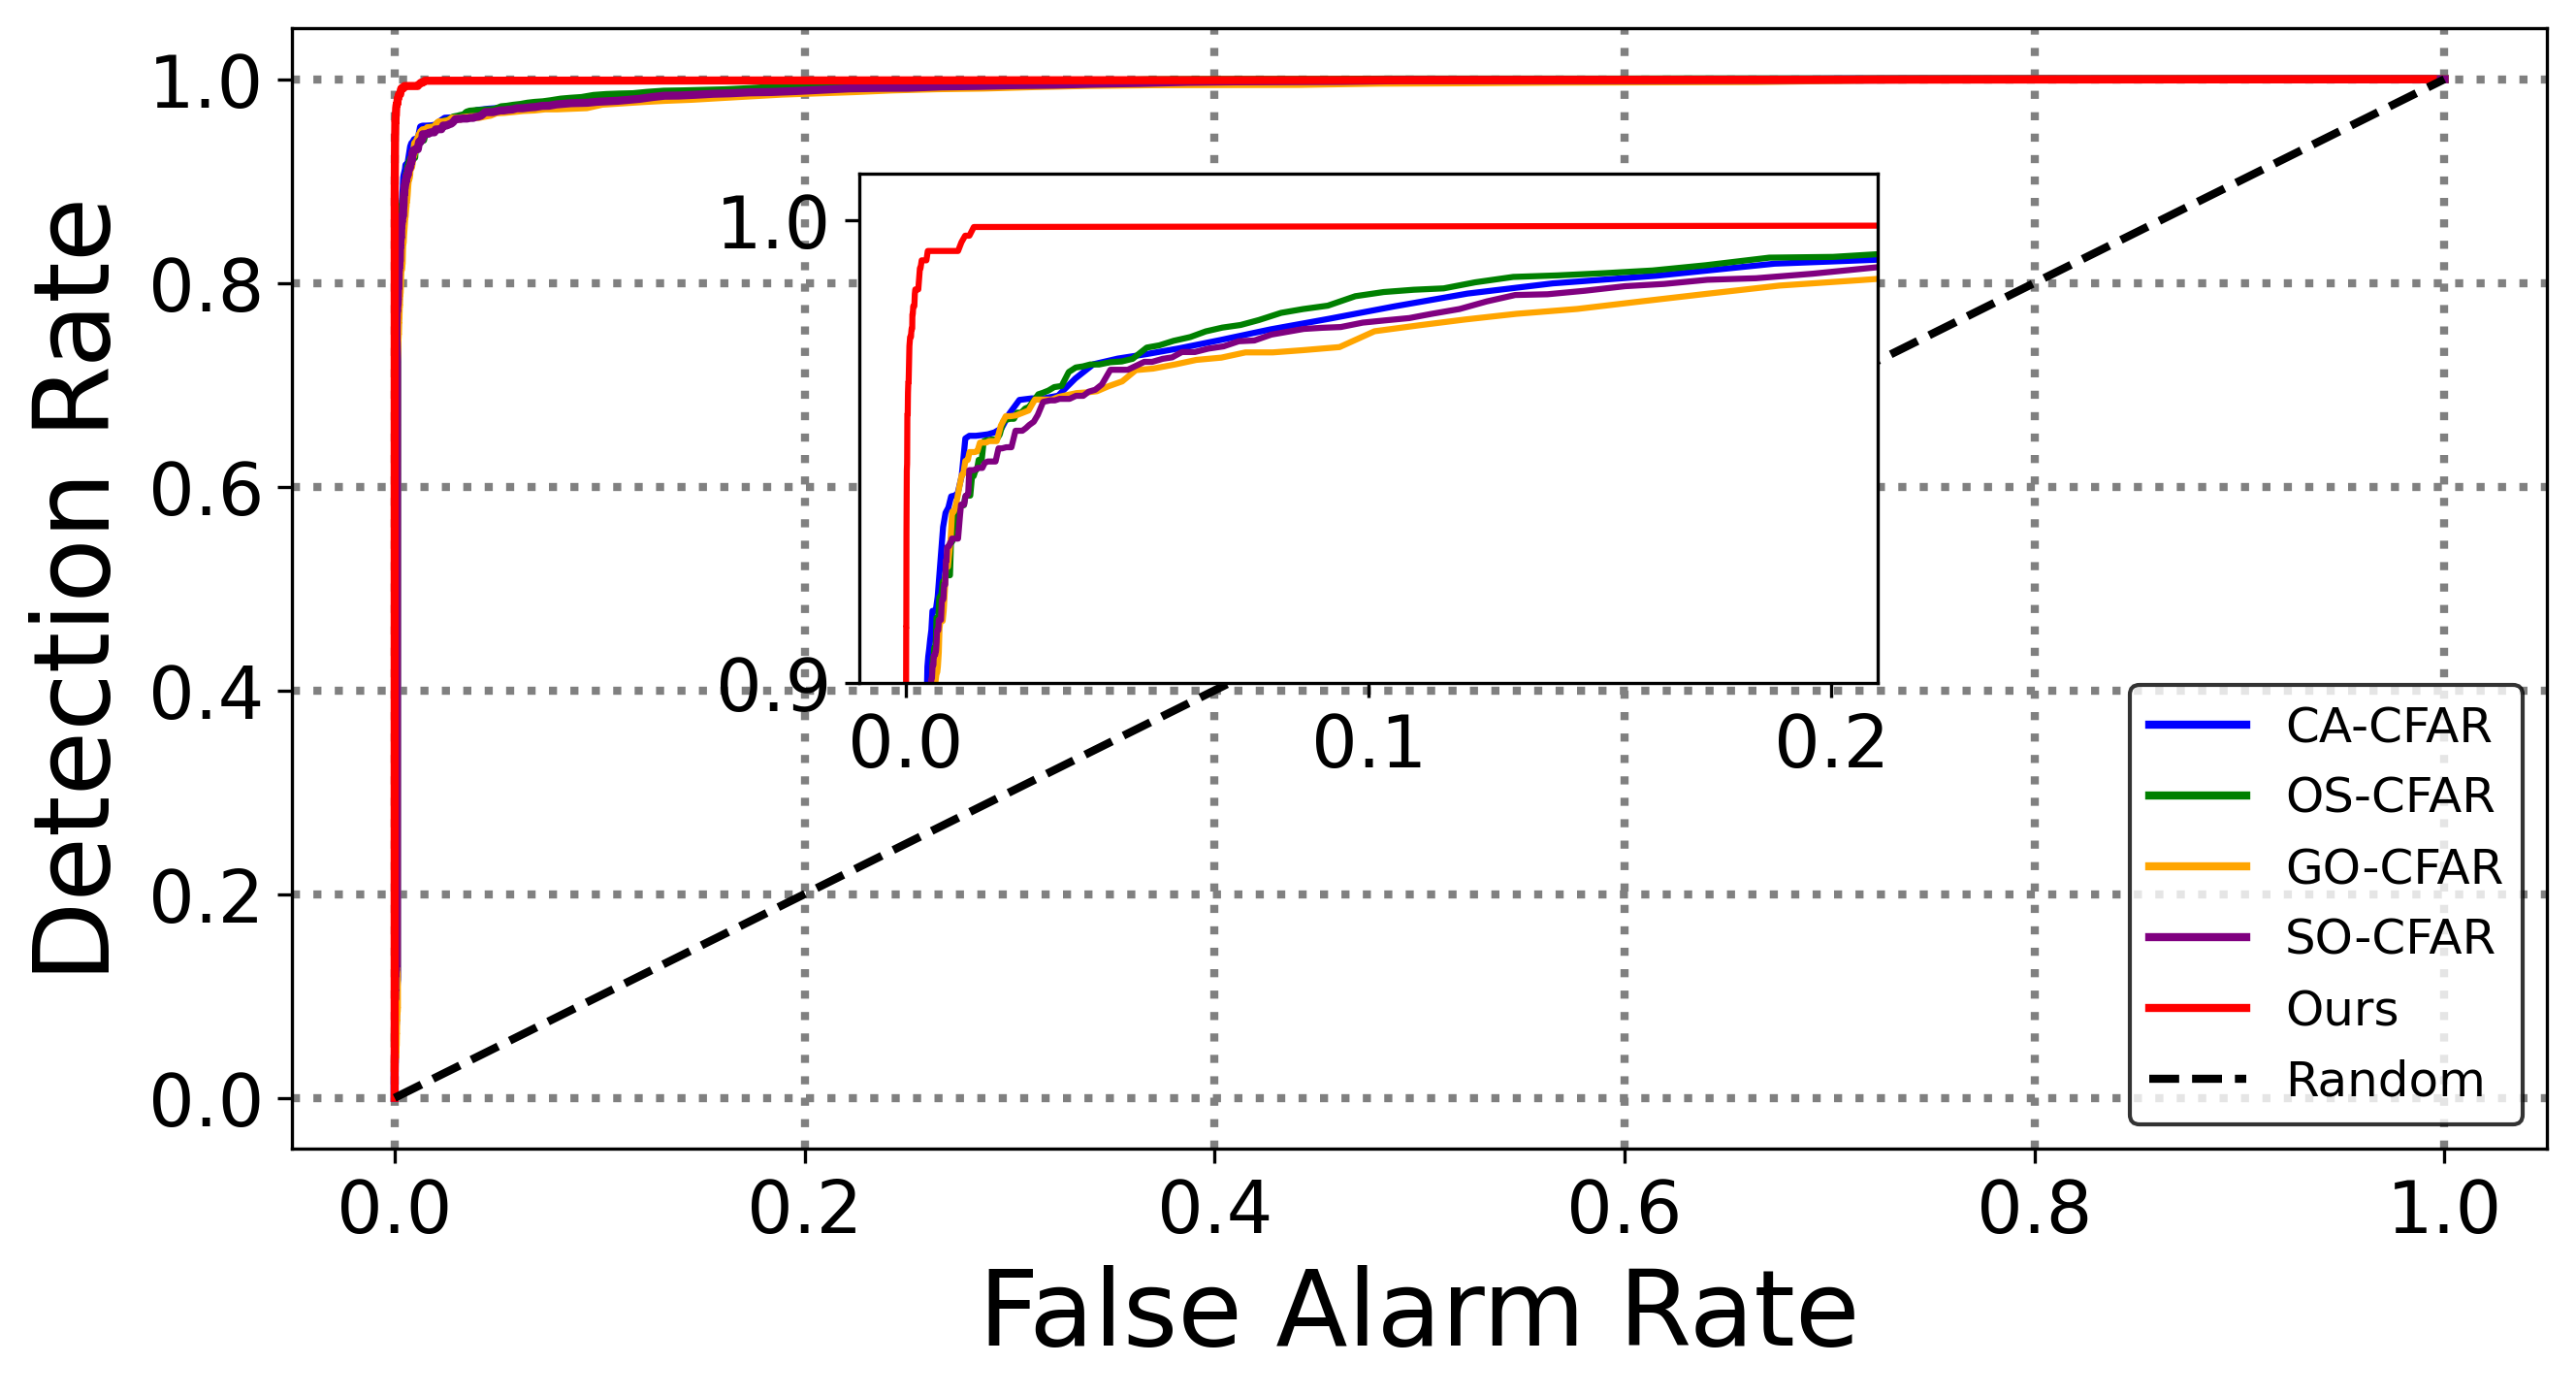

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the CSV files
file_paths = {
    'CA': 'cfar_evaluation_results_CA.csv',
    'OS': 'cfar_evaluation_results_OS.csv',
    'GO': 'cfar_evaluation_results_GO.csv',
    'SO': 'cfar_evaluation_results_SO.csv',
    'Ours': 'evaluation_results.csv'
}

# Read the data
data_ca = pd.read_csv(file_paths['CA'])
data_os = pd.read_csv(file_paths['OS'])
data_go = pd.read_csv(file_paths['GO'])
data_so = pd.read_csv(file_paths['SO'])
data_Ours = pd.read_csv(file_paths['Ours'])

# Set font to Times New Roman
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.labelsize'] = 14  # Enlarge x-axis ticks
plt.rcParams['ytick.labelsize'] = 14  # Enlarge y-axis ticks

# Extract relevant columns for ROC curve (False Alarm Rate vs Detection Rate)
def plot_roc_curve(data, label, color):
    plt.plot(data['False_Alarm_Rate'], data['Detection_Rate'], label=label, linewidth=2, color=color)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 5), facecolor='none', dpi=300)

# Main ROC plot
plot_roc_curve(data_ca, 'CA-CFAR', 'blue')
plot_roc_curve(data_os, 'OS-CFAR', 'green')
plot_roc_curve(data_go, 'GO-CFAR', 'orange')
plot_roc_curve(data_so, 'SO-CFAR', 'purple')
plot_roc_curve(data_Ours, 'Ours', 'red')

# Add diagonal line for random classifier (black dash line)
ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=2)

# Customize the plot
ax.set_xlabel('False Alarm Rate', fontsize=26)
ax.set_ylabel('Detection Rate', fontsize=26)

# Show legend with a black border
ax.legend(loc='lower right', fontsize=12, edgecolor='black')

# No grid for the plot
# ax.grid(False)
ax.grid(True, which='both', linestyle=':', linewidth=2.0, color='gray')

# Enlarge ticks for the main plot
ax.tick_params(axis='both', which='major', labelsize=18)

# Add a zoomed-in subplot
ax_inset = plt.axes([0.32, 0.43, 0.35, 0.35])
ax_inset.plot(data_ca['False_Alarm_Rate'], data_ca['Detection_Rate'], label='CA', color='blue')
ax_inset.plot(data_os['False_Alarm_Rate'], data_os['Detection_Rate'], label='OS', color='green')
ax_inset.plot(data_go['False_Alarm_Rate'], data_go['Detection_Rate'], label='GO', color='orange')
ax_inset.plot(data_so['False_Alarm_Rate'], data_so['Detection_Rate'], label='SO', color='purple')
ax_inset.plot(data_Ours['False_Alarm_Rate'], data_Ours['Detection_Rate'], label='Ours', color='red')
ax_inset.plot([0, 1], [0, 1], 'k--', linewidth=2)

# Zoom in on the false alarm rate and leave space at the corners
ax_inset.set_xlim(-0.01, 0.21)  # Add blank space at the left and right corners
ax_inset.set_ylim(0.9, 1.01)  # Add blank space at the top and bottom corners
ax_inset.grid(False)  # No grid for the inset

# Reduce the number of y-ticks and make them larger
ax_inset.set_yticks([0.9, 1.0])
ax_inset.tick_params(axis='y', labelsize=18)
ax_inset.tick_params(axis='x', labelsize=18)

# Set a transparent background for the plot
# plt.tight_layout()

pdf_path = 'figures/roc_curve.pdf'
plt.savefig(pdf_path, format='pdf', bbox_inches='tight')

plt.show()